In [523]:
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [524]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [525]:
from itertools import *
import pickle
#from hep_ml.reweight import BinsReweighter
import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

In [526]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../utils')
import dem
import classes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [528]:
%pylab inline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class xgbClf:
    xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05, max_depth = 5, min_child_weight = 2)
    xtest_ex = []
    def __init__(self,name = 'default_z'):
        self.name = name
    def fit(self, X_train, y_train):
        print "start fitting"
        self.xgb_clf.fit(dem.rev_(X_train), y_train)
        self.write(self.name)
        print "fitting succeed"
    def count_score(self, X_val, y_val):
        valid_answ = self.xgb_clf.predict_proba(dem.rev_(X_val))
        self.valid_answ = valid_answ
        print "On val:", roc_auc_score(y_val, valid_answ[:,1])
        fpr_, tpr_, thresholds_ = roc_curve(y_val, valid_answ[:,1])
        plt.plot(fpr_, tpr_, label="Roc-Curve")
        
    def predict_prob(self,test_sample):
        return self.xgb_clf.predict_proba(dem.rev_(test_sample))
    def write (self, file_name):
        import pickle
        print "storing classifier in file", file_name,"...",
        pickle.dump(self.xgb_clf, open ('class/'+file_name, "wb"))
        print " ...done"
    #def loads(self, params=None):
        #print "loads", self.name
        #self.xgb_clf._Booster.load_model('class/'+self.name)

Populating the interactive namespace from numpy and matplotlib


## Separate fitting full and boundary square ##

** Stack datasets **

In [529]:
(X_train0,X_val0,y_train0,y_val0, area_train0, area_val0), (X_train_rec0,X_val_rec0,y_train_rec0,y_val_rec0, area_train_rec0, area_val_rec0) = dem.preprocess2('../../../obt_data/Pi0Area0.pcl', '../../../obt_data/PhArea0.pcl')

area list len: 42632 21276
area list len: 63530 37687
X_all shape2 (106162, 2, 5, 5)
arealist shapes (42632, 2) (63530, 2)
(2,)
X_all shape2 (58963, 2, 5, 5)
(2,)


In [530]:
(X_train1,X_val1,y_train1,y_val1, area_train1, area_val1), (X_train_rec1,X_val_rec1,y_train_rec1,y_val_rec1, area_train_rec1, area_val_rec1) = dem.preprocess2('../../../obt_data/Pi0Area1.pcl', '../../../obt_data/PhArea1.pcl')

area list len: 21921 17604
area list len: 39216 40354
X_all shape2 (61137, 2, 5, 5)
arealist shapes (21921, 2) (39216, 2)
(2,)
X_all shape2 (57958, 2, 5, 5)
(2,)


In [531]:
(X_train2,X_val2,y_train2,y_val2, area_train2, area_val2), (X_train_rec2,X_val_rec2,y_train_rec2,y_val_rec2, area_train_rec2, area_val_rec2) = dem.preprocess2('../../../obt_data/Pi0Area2.pcl', '../../../obt_data/PhArea2.pcl')

area list len: 29895 3617
area list len: 45499 9546
X_all shape2 (75394, 2, 5, 5)
arealist shapes (29895, 2) (45499, 2)
(2,)
X_all shape2 (13163, 2, 5, 5)
(2,)


## 0 area ##

start fitting
storing classifier in file 0_simpl ...  ...done
fitting succeed
On val: 0.957644729291


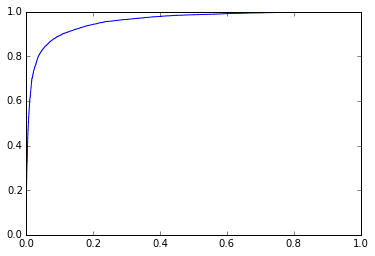

In [535]:
clf0_simple= xgbClf('0_simpl')
clf0_simple.fit(X_train0, y_train0)
clf0_simple.count_score(X_val0, y_val0)

start fitting
storing classifier in file 0_bound ...  ...done
fitting succeed
On val: 0.911529640949


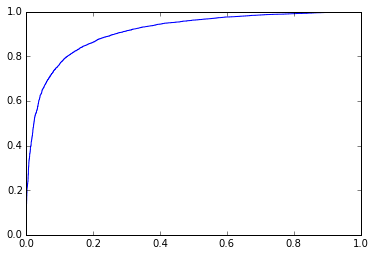

In [536]:
clf0_bound= xgbClf('0_bound')
clf0_bound.fit(X_train_rec0, y_train_rec0)
clf0_bound.count_score(X_val_rec0, y_val_rec0)

## 1 area ##

start fitting
storing classifier in file 1_simpl ...  ...done
fitting succeed
On val: 0.970245440493


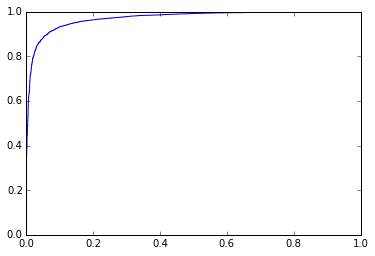

In [537]:
clf1_simple= xgbClf('1_simpl')
clf1_simple.fit(X_train1, y_train1)
clf1_simple.count_score(X_val1, y_val1)

start fitting
storing classifier in file 1_bound ...  ...done
fitting succeed
On val: 0.946242858555


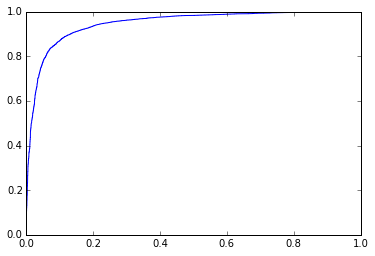

In [538]:
clf1_simple= xgbClf('1_bound')
clf1_simple.fit(X_train_rec1, y_train_rec1)
clf1_simple.count_score(X_val_rec1, y_val_rec1)

## 2 area ##

start fitting
storing classifier in file 2_simpl ...  ...done
fitting succeed
On val: 0.957794440794


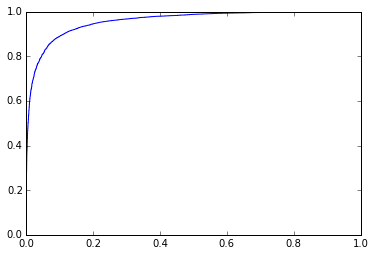

In [539]:
clf2_simple= xgbClf('2_simpl')
clf2_simple.fit(X_train2, y_train2)
clf2_simple.count_score(X_val2, y_val2)

start fitting
storing classifier in file 2_bound ...  ...done
fitting succeed
On val: 0.962024624851


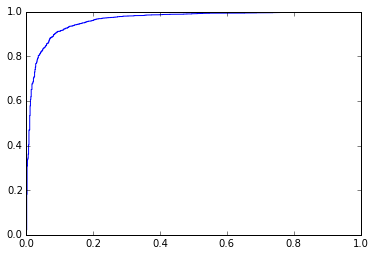

In [540]:
clf2_bound= xgbClf('2_bound')
clf2_bound.fit(X_train_rec2, y_train_rec2)
clf2_bound.count_score(X_val_rec2, y_val_rec2)

## Common classifier ##

In [542]:
classifiers = {0:{0:clf0_simple, 1:clf0_bound}, 1:{0:clf1_simple, 1:clf1_bound}, 2:{0:clf2_simple, 1:clf2_bound}}

In [557]:
print clf0_simple, classifiers[0][0]
print clf0_bound, classifiers[0][1]
print clf1_simple, classifiers[1][0]
print clf1_bound, classifiers[1][1]
print clf2_simple, classifiers[2][0]
print clf2_bound, classifiers[2][1]


<__main__.xgbClf instance at 0x7fae0dc3d710> <__main__.xgbClf instance at 0x7fae0dc3d710>
<__main__.xgbClf instance at 0x7fae0dc5ffc8> <__main__.xgbClf instance at 0x7fae0dc5ffc8>
<__main__.xgbClf instance at 0x7fae0d80ecb0> <__main__.xgbClf instance at 0x7fae0d80ecb0>
<__main__.xgbClf instance at 0x7fade408e098> <__main__.xgbClf instance at 0x7fade408e098>
<__main__.xgbClf instance at 0x7fae0d1116c8> <__main__.xgbClf instance at 0x7fae0d1116c8>
<__main__.xgbClf instance at 0x7fadf60f4d40> <__main__.xgbClf instance at 0x7fadf60f4d40>


In [550]:
map(len,[X_val0, X_val1, X_val2, X_val_rec0, X_val_rec, X_val_rec2])

[26541, 15285, 18849, 14741, 10993, 3291]

In [551]:
map(len,[y_val0, y_val1, y_val2, y_val_rec0, y_val_rec, y_val_rec2])

[26541, 15285, 18849, 14741, 10993, 3291]

In [552]:
X_common_val = np.concatenate([X_val0, X_val1, X_val2, X_val_rec0, X_val_rec1, X_val_rec2], axis = 0)
Y_common_val = np.concatenate([y_val0, y_val1, y_val2, y_val_rec0, y_val_rec1, y_val_rec2], axis = 0)
Common_clf = np.concatenate([area_val0, area_val1, area_val2, area_val_rec0, area_val_rec1, area_val_rec2], axis = 0)
shuffle_ind = np.arange(len(X_common_val))
np.random.shuffle(shuffle_ind)
X_common_val = X_common_val[shuffle_ind]
Y_common_val = Y_common_val[shuffle_ind]
Common_clf = Common_clf[shuffle_ind]

In [553]:
def common_prediction(X_common_val, Common_clf):
    answ = []
    print 'common prediction'
    for (X_val, clf) in (zip(X_common_val, Common_clf)):
        try:
            clf_name = classifiers[clf[0]][clf[1]].name
            clf_partial = xgbClf()
            clf_partial.xgb_clf = pickle.load (open ('class/'+clf_name, "rb"))
            answ.append(clf_partial.xgb_clf.predict_proba(X_val.ravel().reshape((1,50))))
            if len(answ)%500 == 0:
                print len(answ)
        except:
            print "clf", clf
            break
    return answ


In [554]:
answ_common = common_prediction(X_common_val, Common_clf)

common prediction
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500


On val: 0.93252628449


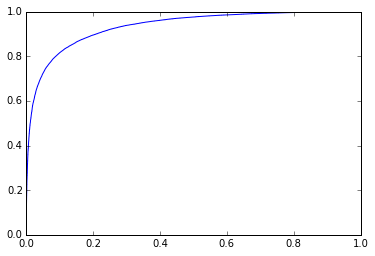

In [555]:
predict_answ = np.array(answ_common).reshape((len(answ_common), 2))[:,1]
print "On val:", roc_auc_score(Y_common_val, predict_answ)
fpr_, tpr_, thresholds_ = roc_curve(Y_common_val,predict_answ)
plt.plot(fpr_, tpr_, label="Roc-Curve")

## TRY only X area ##

In [511]:
len(X_val0)

26541

In [514]:
answ = []
for (X_val, clf) in (zip(X_val0[:1000], area_val0[:1000])):
    clf_name = classifiers[clf[0]][clf[1]].name
    clf_partial = xgbClf()
    clf_partial.xgb_clf = pickle.load (open ('class/'+clf_name, "rb"))
    answ.append(clf_partial.xgb_clf.predict_proba(X_val.ravel().reshape((1,50))))
    if len(answ)%500 == 0:
        print len(answ)

500
1000


In [516]:
predict_answ = np.array(answ).reshape((len(answ), 2))[:,1]
print "On val:", roc_auc_score(y_val0[:1000], predict_answ)

 On val: 0.96201155892


common prediction new
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
loads 0_simpl
10
On val: 0.5


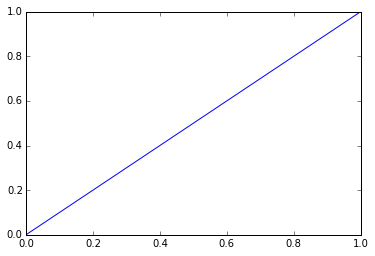

In [491]:
names = []
answ_val0 = common_prediction(X_val0[:10], area_val0[:10])
print len(answ_val0)
predict_answ = np.array(answ_val0).reshape((len(answ_val0), 2))[:,1]
print "On val:", roc_auc_score(y_val0[:10], predict_answ)
fpr_, tpr_, thresholds_ = roc_curve(y_val0[:10], predict_answ)
plt.plot(fpr_, tpr_, label="Roc-Curve")

common prediction new
On val: 0.957357197754


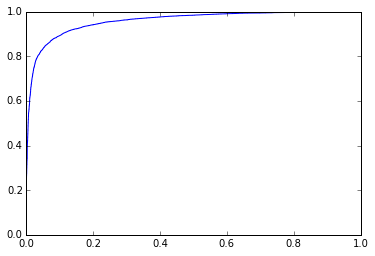

In [408]:
names = []
answ_val0 = common_prediction1(X_val0, area_val0, names)
predict_answ = np.array(answ_val0).reshape((len(answ_val0), 2))[:,1]
print "On val:", roc_auc_score(y_val0, predict_answ)
fpr_, tpr_, thresholds_ = roc_curve(y_val0, predict_answ)
plt.plot(fpr_, tpr_, label="Roc-Curve")